In [21]:
from google.colab import drive
drive.mount("/content/drive")

!pip -q install timm pandas


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
from pathlib import Path
import json
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

import timm


In [23]:
PROJECT_ROOT = Path("/content/drive/MyDrive/SkinCare_AI_Component")

# ✅ update if your file name is different
CKPT_PATH = PROJECT_ROOT / "models/vision/skin_type_convnext_cleaned_best.pt"
assert CKPT_PATH.exists(), f"❌ Missing checkpoint: {CKPT_PATH}"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

ckpt = torch.load(CKPT_PATH, map_location=device)

label_map = ckpt["label_map"]                 # e.g., {"oily":0,"dry":1,"combination":2}
id_to_label = {v: k for k, v in label_map.items()}
num_classes = len(label_map)

MODEL_NAME = ckpt["model_name"]
model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=num_classes).to(device)
model.load_state_dict(ckpt["model_state"], strict=True)
model.eval()

softmax = nn.Softmax(dim=1)

print("✅ Loaded checkpoint:", CKPT_PATH)
print("✅ Model:", MODEL_NAME)
print("✅ Classes:", label_map)


Device: cpu
✅ Loaded checkpoint: /content/drive/MyDrive/SkinCare_AI_Component/models/vision/skin_type_convnext_cleaned_best.pt
✅ Model: convnext_tiny
✅ Classes: {'oily': 0, 'dry': 1, 'combination': 2}


In [24]:
IMG_SIZE = 224
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

@torch.no_grad()
def predict_image(image_path: str):
    img = Image.open(image_path).convert("RGB")
    x = tfm(img).unsqueeze(0).to(device)
    logits = model(x)
    probs = softmax(logits).cpu().numpy().flatten()
    pred_id = int(np.argmax(probs))
    return probs, pred_id


In [25]:
META_DIR = PROJECT_ROOT / "data/11_skin_type/metadata"
INDEX_CSV = META_DIR / "image_index_skin_type.csv"
assert INDEX_CSV.exists(), f"❌ Missing: {INDEX_CSV}"

df = pd.read_csv(INDEX_CSV)
df_test = df[df["split"] == "test"].reset_index(drop=True)
assert len(df_test) > 0, "❌ Test split is empty."

# pick first test image (change index if you want)
row = df_test.iloc[0]
TRUE_LABEL = row["label_name"]

img_path = Path(row["image_path"])
img_path = img_path if img_path.is_absolute() else (PROJECT_ROOT / img_path)
assert img_path.exists(), f"❌ Test image not found: {img_path}"

print("✅ Using test image:", img_path)
print("✅ True label:", TRUE_LABEL)


✅ Using test image: /content/drive/MyDrive/SkinCare_AI_Component/data/11_skin_type/splits/test/oily/e6fef51143f660a865aa46ada857b430_jpg.rf.ff3cbf4d39aac162319e5abdf80fe8fa.jpg
✅ True label: oily


In [26]:
def ask_yes_no(question: str) -> int:
    """
    Returns: 1 for Yes, 0 for No
    """
    while True:
        ans = input(f"{question} (Yes/No): ").strip().lower()
        if ans in ("yes", "y"):
            return 1
        if ans in ("no", "n"):
            return 0
        print("❌ Please type Yes or No (example: Yes / No).")


def questionnaire_probs(q_oily, q_dry, q_tzone, label_map):
    """
    Convert questionnaire answers into a probability distribution P_q.
    This is NOT trained. It's rule-based and interpretable.
    """
    q = np.ones(len(label_map), dtype=np.float64) * 0.10  # small prior

    if "oily" in label_map:
        q[label_map["oily"]] += 0.80 * q_oily
    if "dry" in label_map:
        q[label_map["dry"]] += 0.80 * q_dry
    if "combination" in label_map:
        q[label_map["combination"]] += 0.80 * q_tzone

    q = np.clip(q, 1e-9, None)
    q = q / q.sum()
    return q


def fuse_probs(p_img, p_q, alpha=0.75):
    """
    Weighted fusion:
      P_final = alpha * P_img + (1-alpha) * P_q
    alpha closer to 1 means we trust the image model more.
    """
    p_final = alpha * p_img + (1 - alpha) * p_q
    p_final = np.clip(p_final, 1e-9, None)
    p_final = p_final / p_final.sum()
    final_id = int(np.argmax(p_final))
    return final_id, p_final


In [27]:
# 1) Image-only prediction
p_img, pred_img = predict_image(str(img_path))

print("\n📌 Image Model Probabilities (P_img):")
for i in range(num_classes):
    print(f"{id_to_label[i]:<12}: {p_img[i]:.4f}")

print("\n🧾 Skin Behavior Questions (Answer Yes/No)\n")

# 2) Conditional questionnaire to avoid contradictions
q_oily = ask_yes_no(
    "1) Does your face usually become oily or shiny within 2–3 hours after washing?"
)

q_dry = 0
q_tzone = 0

if q_oily == 0:
    q_dry = ask_yes_no(
        "2) Does your skin often feel dry, tight, or flaky after washing?"
    )
else:
    q_tzone = ask_yes_no(
        "2) Is oiliness mainly in the T-zone (forehead/nose/chin), while cheeks feel normal or dry?"
    )

# 3) Questionnaire probabilities
p_q = questionnaire_probs(q_oily, q_dry, q_tzone, label_map)

print("\n📌 Questionnaire Probabilities (P_q):")
for i in range(num_classes):
    print(f"{id_to_label[i]:<12}: {p_q[i]:.4f}")

# 4) Fusion
ALPHA = 0.75
final_id, p_final = fuse_probs(p_img, p_q, alpha=ALPHA)

print("\n🧠 Fusion Explanation")
print(f"P_final = {ALPHA:.2f} * P_img + {1-ALPHA:.2f} * P_q")
print(f"Answers: oily={q_oily}, dry={q_dry}, tzone={q_tzone}")

print("\n✅ FINAL SYSTEM OUTPUT")
print("True label (from test):", TRUE_LABEL)
print("Image-only prediction:", id_to_label[pred_img])
print("Final fused prediction:", id_to_label[final_id])

print("\n📌 Final Probabilities (P_final):")
for i in range(num_classes):
    print(f"{id_to_label[i]:<12}: {p_final[i]:.4f}")



📌 Image Model Probabilities (P_img):
oily        : 0.9965
dry         : 0.0034
combination : 0.0000

🧾 Skin Behavior Questions (Answer Yes/No)

1) Does your face usually become oily or shiny within 2–3 hours after washing? (Yes/No): yes
2) Is oiliness mainly in the T-zone (forehead/nose/chin), while cheeks feel normal or dry? (Yes/No): no

📌 Questionnaire Probabilities (P_q):
oily        : 0.8182
dry         : 0.0909
combination : 0.0909

🧠 Fusion Explanation
P_final = 0.75 * P_img + 0.25 * P_q
Answers: oily=1, dry=0, tzone=0

✅ FINAL SYSTEM OUTPUT
True label (from test): oily
Image-only prediction: oily
Final fused prediction: oily

📌 Final Probabilities (P_final):
oily        : 0.9519
dry         : 0.0253
combination : 0.0228


In [28]:
OUT_DIR = PROJECT_ROOT / "results/skin_type"
OUT_DIR.mkdir(parents=True, exist_ok=True)

out_json = OUT_DIR / "final_system_demo_result.json"

demo_record = {
    "image_path": str(img_path),
    "true_label": str(TRUE_LABEL),

    "image_only_probs": {id_to_label[i]: float(p_img[i]) for i in range(num_classes)},
    "image_only_pred": str(id_to_label[pred_img]),

    "questionnaire_answers": {
        "oily_within_2_3_hours": "Yes" if q_oily == 1 else "No",
        "dry_tight_flaky_after_washing": ("Yes" if q_dry == 1 else "No") if q_oily == 0 else "Not asked",
        "tzone_oily_while_cheeks_normal_or_dry": ("Yes" if q_tzone == 1 else "No") if q_oily == 1 else "Not asked",
    },

    "P_q": {id_to_label[i]: float(p_q[i]) for i in range(num_classes)},
    "fusion_alpha": float(ALPHA),
    "P_final": {id_to_label[i]: float(p_final[i]) for i in range(num_classes)},
    "final_fused_pred": str(id_to_label[final_id]),
}

with open(out_json, "w") as f:
    json.dump(demo_record, f, indent=2)

print("✅ Saved demo JSON:", out_json)


✅ Saved demo JSON: /content/drive/MyDrive/SkinCare_AI_Component/results/skin_type/final_system_demo_result.json


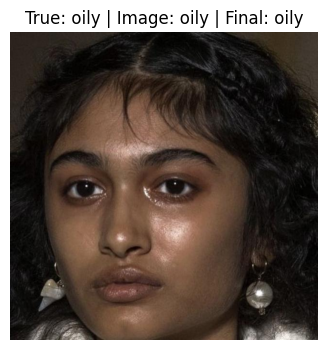

In [29]:
import matplotlib.pyplot as plt

img = Image.open(img_path).convert("RGB")
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis("off")
plt.title(f"True: {TRUE_LABEL} | Image: {id_to_label[pred_img]} | Final: {id_to_label[final_id]}")
plt.show()


In [30]:
# ✅ CELL 10 — Report-ready System Flow + Fusion Pseudocode (Auto-generate text files)

from pathlib import Path

OUT_DIR = PROJECT_ROOT / "results/skin_type"
OUT_DIR.mkdir(parents=True, exist_ok=True)

flow_txt = OUT_DIR / "final_system_flow.txt"
pseudo_txt = OUT_DIR / "final_system_pseudocode.txt"
method_txt = OUT_DIR / "final_system_method_paragraph.txt"

# --- 1) System flow (for report)
flow_content = """FINAL SKIN TYPE SYSTEM FLOW (IMAGE + QUESTIONNAIRE FUSION)

Input:
  - Facial selfie image
  - User answers to a short yes/no questionnaire

Step 1: Image Model Inference
  - Preprocess image (resize 224x224, normalize with ImageNet mean/std)
  - ConvNeXt model outputs probability distribution:
      P_img = [P(oily), P(dry), P(combination)]

Step 2: Conditional Questionnaire
  - Q1: "Does your face become oily/shiny within 2–3 hours after washing?"
  - If Q1 = No:
      Q2: "Does your skin feel dry/tight/flaky after washing?"
    Else (Q1 = Yes):
      Q2: "Is oiliness mainly in the T-zone while cheeks are normal/dry?"

  - Convert answers into questionnaire probabilities:
      P_q = [P(oily), P(dry), P(combination)]

Step 3: Weighted Fusion
  - Combine both probability vectors using:
      P_final = alpha * P_img + (1 - alpha) * P_q
  - Final prediction = argmax(P_final)

Output:
  - Final skin type class and confidence (P_final)
"""

# --- 2) Pseudocode (for report)
pseudo_content = f"""PSEUDOCODE — FINAL SKIN TYPE SYSTEM (IMAGE + QUESTIONNAIRE)

Given:
  image I
  trained image model M
  fusion weight alpha = {ALPHA:.2f}

1) Image inference:
   P_img = softmax(M(preprocess(I)))

2) Ask questionnaire (conditional):
   q_oily = ask_yesno("Oily/shiny within 2–3 hours after washing?")
   q_dry = 0
   q_tzone = 0

   if q_oily == 0:
       q_dry = ask_yesno("Dry/tight/flaky after washing?")
   else:
       q_tzone = ask_yesno("Oily mainly in T-zone while cheeks normal/dry?")

3) Convert answers to questionnaire distribution P_q:
   initialize P_q with small prior for all classes
   if q_oily == 1: increase P_q[oily]
   if q_dry  == 1: increase P_q[dry]
   if q_tzone== 1: increase P_q[combination]
   normalize P_q to sum to 1

4) Fuse:
   P_final = alpha * P_img + (1 - alpha) * P_q
   normalize P_final

5) Predict:
   y_final = argmax(P_final)

Return y_final, P_final
"""

# --- 3) Method paragraph (copy-paste into report)
method_content = f"""METHOD DESCRIPTION — FINAL SKIN TYPE SYSTEM (FOR REPORT)

A hybrid skin-type assessment system was developed by combining an image-based deep learning model with a lightweight user questionnaire.
First, a ConvNeXt image classifier predicts a probability distribution over skin types (oily, dry, combination) from a facial selfie image, producing P_img.
Since skin type depends on time-dependent skin behavior (e.g., oiliness after washing and T-zone patterns) that cannot be reliably inferred from a single image, a short conditional yes/no questionnaire is used to obtain complementary evidence.
User responses are converted into a questionnaire probability distribution P_q.
The final decision is computed using a weighted probability fusion:
P_final = alpha·P_img + (1−alpha)·P_q, where alpha = {ALPHA:.2f} controls the contribution of the image model relative to the questionnaire.
The final skin type is selected as the class with the highest probability in P_final.
This fusion strategy improves interpretability and robustness while keeping the system simple and suitable for deployment.
"""

flow_txt.write_text(flow_content)
pseudo_txt.write_text(pseudo_content)
method_txt.write_text(method_content)

print("✅ Saved flow diagram text:", flow_txt)
print("✅ Saved pseudocode text:", pseudo_txt)
print("✅ Saved report paragraph:", method_txt)

print("\n--- Preview: final_system_method_paragraph.txt ---\n")
print(method_content)


✅ Saved flow diagram text: /content/drive/MyDrive/SkinCare_AI_Component/results/skin_type/final_system_flow.txt
✅ Saved pseudocode text: /content/drive/MyDrive/SkinCare_AI_Component/results/skin_type/final_system_pseudocode.txt
✅ Saved report paragraph: /content/drive/MyDrive/SkinCare_AI_Component/results/skin_type/final_system_method_paragraph.txt

--- Preview: final_system_method_paragraph.txt ---

METHOD DESCRIPTION — FINAL SKIN TYPE SYSTEM (FOR REPORT)

A hybrid skin-type assessment system was developed by combining an image-based deep learning model with a lightweight user questionnaire.
First, a ConvNeXt image classifier predicts a probability distribution over skin types (oily, dry, combination) from a facial selfie image, producing P_img.
Since skin type depends on time-dependent skin behavior (e.g., oiliness after washing and T-zone patterns) that cannot be reliably inferred from a single image, a short conditional yes/no questionnaire is used to obtain complementary evidence.